## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import ERA5_functions as era_fncts
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('aht_time_series/era5_aht_time_series.nc')

### First let's just look at zonal-mean dry-moist things

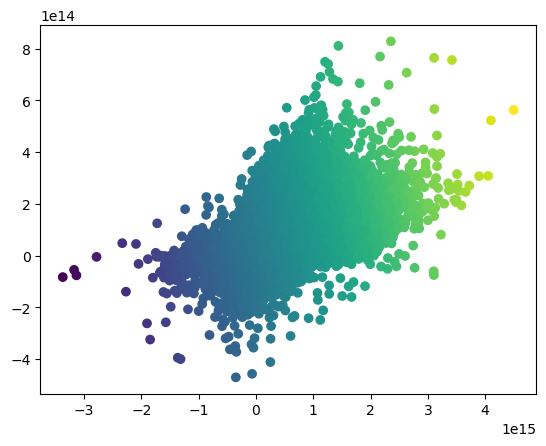

In [34]:
which_lat = 80

plt.scatter(aht_ds.eddy_aht_dry.sel(latitude=which_lat).values, aht_ds.eddy_aht_moist.sel(latitude=which_lat).values,
           c=aht_ds.eddy_aht.sel(latitude=which_lat).values)

plt.show()

### Now let's look at local AHT things

In [37]:
ddir = 'aht_time_series/one_lat/eddy_total_'
local_aht_dict = {}

lats_subset = [35, 40, 45, 50, 55, 60, 65, 70]
for lat in lats_subset:
    eddy_data = []
    eddy_files = sorted(glob(ddir + str(lat) + '*' + '1980' + '*'))
    for file in eddy_files:
        file_data = np.load(file)
        eddy_data.append(file_data)

    eddy_local = np.concatenate(eddy_data)
    local_aht_dict[lat] = eddy_local

In [40]:
ddir = 'aht_time_series/moist_aht/eddy_moist_'
local_aht_dict_moist = {}

lats_subset = [35, 40, 45, 50, 55, 60, 65, 70]
for lat in lats_subset:
    eddy_data = []
    eddy_files = sorted(glob(ddir + str(lat) + '*' + '1980' + '*'))
    for file in eddy_files:
        file_data = np.load(file)
        eddy_data.append(file_data)

    eddy_local = np.concatenate(eddy_data)
    local_aht_dict_moist[lat] = eddy_local

In [41]:
local_aht_dict_dry = {}

for lat in lats_subset:
    local_aht_dict_dry[lat] = local_aht_dict[lat] - local_aht_dict_moist[lat]

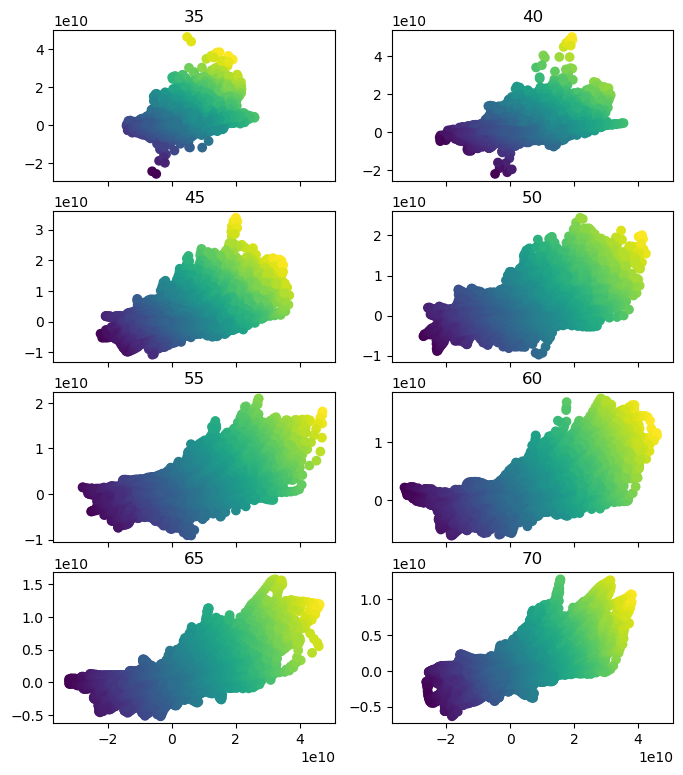

In [44]:
fig, axs = plt.subplots(4, 2, sharex=True, figsize=(8, 9))

for idx, ax in enumerate(axs.flatten()):
    
    which_lat = lats_subset[idx]
    ax.scatter(local_aht_dict_dry[which_lat].flatten(), local_aht_dict_moist[which_lat].flatten(),
               c=local_aht_dict[which_lat].flatten())
    
    ax.set_title(which_lat)
    
plt.show()

In [55]:
def get_extremes(eddy_local, ndjf=False):
    

    
    extreme_ratio = np.zeros(720)

    for i in range(720):
        data_sorted = np.sort(eddy_local[:,i])
        
        if np.mean(eddy_local[:,i]) > 0:
            data_sorted = np.sort(eddy_local[:,i])
            new_datas = eddy_local[:,i][eddy_local[:,i]>0]
        elif np.mean(eddy_local[:,i]) <= 0:
            data_sorted = np.sort(eddy_local[:,i])[::-1]
            new_datas = eddy_local[:,i][eddy_local[:,i]<0]
        
        data_top_5_perc = data_sorted[int(0.95 * len(data_sorted)):]

        extreme_ratio[i] = np.sum(data_top_5_perc) / np.sum(new_datas)
        
        if np.mean(data_sorted) < 0:
            extreme_ratio[i] = 10
        else:
            pass
    
    return extreme_ratio

In [56]:
extreme_ratios = np.zeros((len(lats_subset), 720))
extreme_ratios_dry = np.zeros((len(lats_subset), 720))
extreme_ratios_moist = np.zeros((len(lats_subset), 720))

for i, lat in enumerate(lats_subset):
    extreme_ratios[i,:] = get_extremes(local_aht_dict[lat])
    extreme_ratios_dry[i,:] = get_extremes(local_aht_dict_dry[lat])
    extreme_ratios_moist[i,:] = get_extremes(local_aht_dict_moist[lat])
    

In [63]:
local_aht_array = [(v) for k, v in local_aht_dict.items()]
local_aht_array_dry = [(v) for k, v in local_aht_dict_dry.items()]
local_aht_array_moist = [(v) for k, v in local_aht_dict_moist.items()]

<ipython-input-166-e095150b4d24>:19: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  contf.cmap.set_over('grey')
<ipython-input-166-e095150b4d24>:46: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  contf.cmap.set_over('grey')
<ipython-input-166-e095150b4d24>:73: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(m

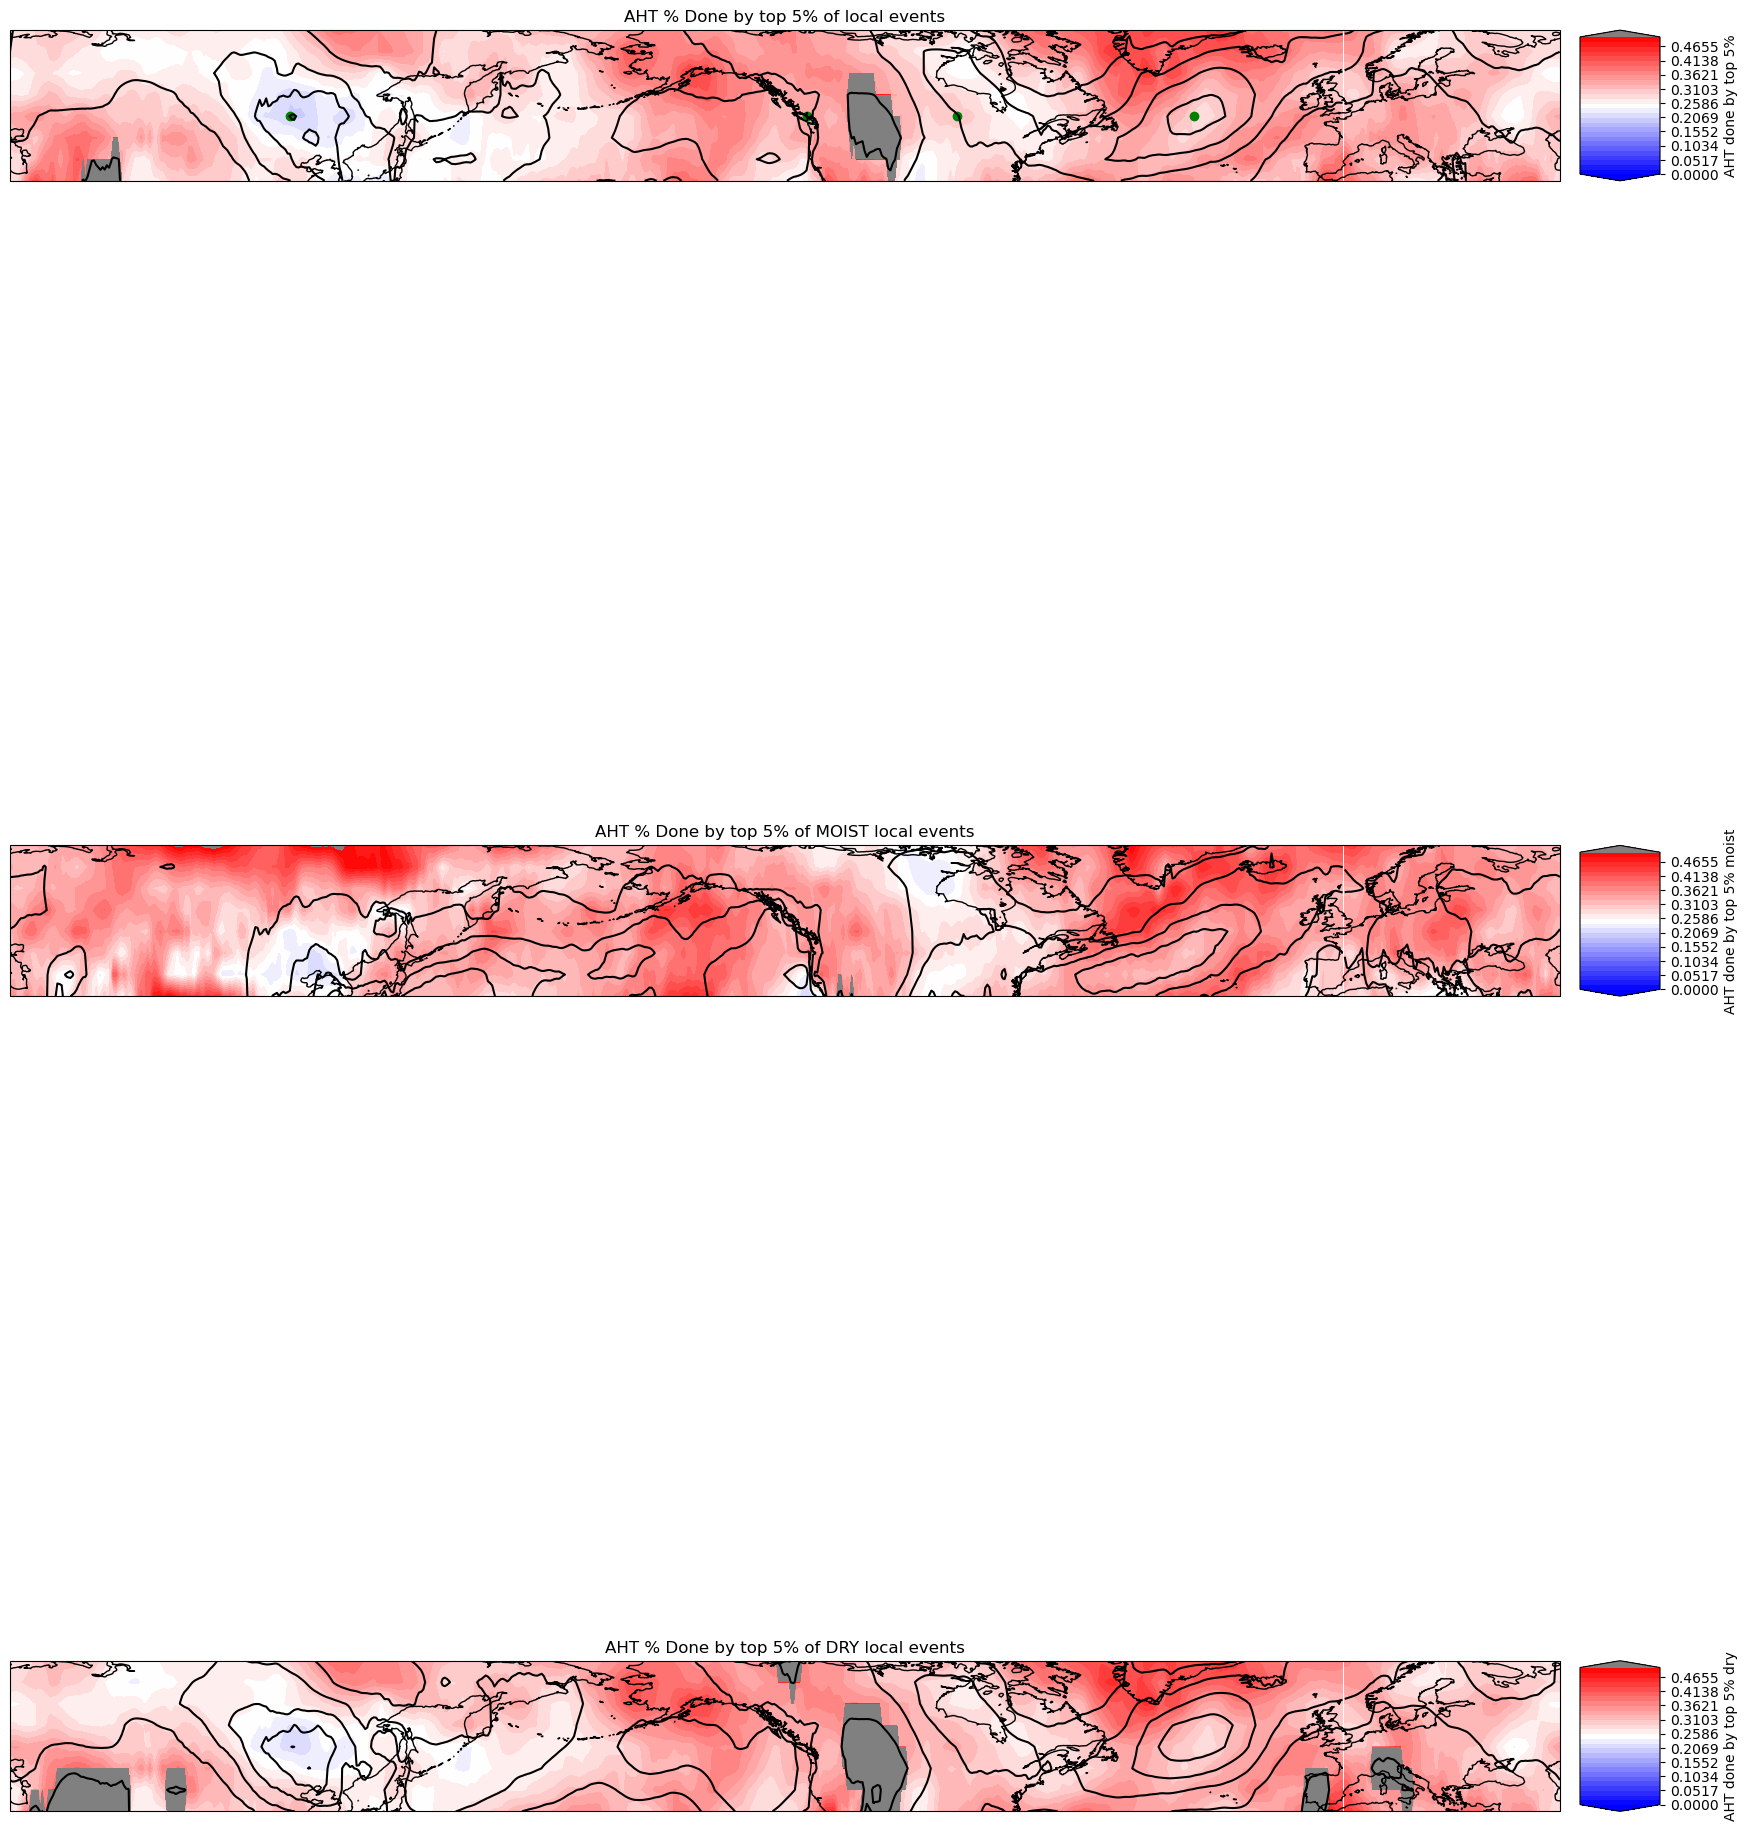

In [166]:
#fig=plt.figure(figsize=(20,30))
fig, axs = plt.subplots(3, 1, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-130)})

#ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-130))
for ax in axs:
    ax.coastlines()

contf = axs[0].contourf(lons, lats_subset, extreme_ratios, levels=np.linspace(0, .5, 30), cmap='bwr',
                    transform=ccrs.PlateCarree(), extend='both')

axs[0].contour(lons, lats_subset, np.mean(local_aht_array, axis=1), colors='k', levels=np.linspace(0, 7e9, 8),
               transform=ccrs.PlateCarree())

axs[0].scatter(lons[230], lats_subset[3], transform=ccrs.PlateCarree(), color='green')
axs[0].scatter(lons[470], lats_subset[3], transform=ccrs.PlateCarree(), color='green')
axs[0].scatter(lons[540], lats_subset[3], transform=ccrs.PlateCarree(), color='green')
axs[0].scatter(lons[650], lats_subset[3], transform=ccrs.PlateCarree(), color='green')

contf.cmap.set_over('grey')
#contf.cmap.set_under('grey')
contf.changed()

#ax.contour(lons, test_lats, extreme_ratios, levels=[0.55], colors='limegreen', transform=ccrs.PlateCarree())

#get size and extent of axes:
axpos = axs[0].get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])


plt.colorbar(contf, cax=pos_cax, label='AHT done by top 5%')

axs[0].set_title('AHT % Done by top 5% of local events')

contf_moist = axs[1].contourf(lons, lats_subset, extreme_ratios_moist, levels=np.linspace(0, .5, 30), cmap='bwr',
                    transform=ccrs.PlateCarree(), extend='both')

axs[1].contour(lons, lats_subset, np.mean(local_aht_array_moist, axis=1), colors='k', levels=np.linspace(0, 2e9, 8),
               transform=ccrs.PlateCarree())

contf.cmap.set_over('grey')
#contf.cmap.set_under('grey')
contf.changed()

#ax.contour(lons, test_lats, extreme_ratios, levels=[0.55], colors='limegreen', transform=ccrs.PlateCarree())

#get size and extent of axes:
axpos = axs[1].get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])


plt.colorbar(contf_moist, cax=pos_cax, label='AHT done by top 5% moist')

axs[1].set_title('AHT % Done by top 5% of MOIST local events')

contf_dry = axs[2].contourf(lons, lats_subset, extreme_ratios_dry, levels=np.linspace(0, .5, 30), cmap='bwr',
                    transform=ccrs.PlateCarree(), extend='both')

axs[2].contour(lons, lats_subset, np.mean(local_aht_array_dry, axis=1), colors='k', levels=np.linspace(0, 5e9, 8),
               transform=ccrs.PlateCarree())

contf.cmap.set_over('grey')
#contf.cmap.set_under('grey')
contf.changed()

#ax.contour(lons, test_lats, extreme_ratios, levels=[0.55], colors='limegreen', transform=ccrs.PlateCarree())

#get size and extent of axes:
axpos = axs[2].get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])


plt.colorbar(contf_dry, cax=pos_cax, label='AHT done by top 5% dry')

axs[2].set_title('AHT % Done by top 5% of DRY local events')
#plt.savefig('figures/3_15_22_meeting/eddy_aht_top_5_perc_local_percent')
plt.show()

In [135]:
ddir1 = 'aht_time_series/one_lat/eddy_total_'

eddy_data = []
eddy_files = sorted(glob(ddir1 + str(50) + '*'))
for file in eddy_files:
    file_data = np.load(file)
    eddy_data.append(file_data)

eddy_local_50 = np.concatenate(eddy_data)

ddir2 = 'aht_time_series/moist_aht/eddy_moist_'
eddy_data = []
eddy_files = sorted(glob(ddir2 + str(50) + '*'))
for file in eddy_files:
    file_data = np.load(file)
    eddy_data.append(file_data)

eddy_local_50_moist = np.concatenate(eddy_data)

In [136]:
eddy_local_50_moist = eddy_local_50_moist[:len(eddy_local_50[:,0].flatten()),:]
eddy_local_50_dry = eddy_local_50 - eddy_local_50_moist

In [225]:
eddy_local_50_ndjf = np.zeros((18760, len(lons)))
eddy_local_50_ndjf_dry = np.zeros((18760, len(lons)))
eddy_local_50_ndjf_moist = np.zeros((18760, len(lons)))

for idx,lon in enumerate(lons):
    eddy_local_50_ndjf[:,idx] = era_fncts.get_ndjf_data(eddy_local_50[:,idx])
    eddy_local_50_ndjf_dry[:,idx] = era_fncts.get_ndjf_data(eddy_local_50_dry[:,idx])
    eddy_local_50_ndjf_moist[:,idx] = era_fncts.get_ndjf_data(eddy_local_50_moist[:,idx])

In [138]:
def get_top_5_gaus(datas):   
    
    n_samples = 5000
    
    mu = np.mean(datas)
    sigma = np.std(datas)
    
    gaus_samples = np.random.normal(mu, sigma, n_samples)
    
    gaus_samples_sorted = np.sort(gaus_samples)
    
    new_data = gaus_samples[gaus_samples>0]
    
    top_5_perc = np.sum(gaus_samples_sorted[int(len(gaus_samples_sorted) * 0.95):]) / np.sum(new_data)
    
    return top_5_perc

In [249]:
def top_5_perc(datas):
    '''Calculate the contribution from the top 5% of events
    '''

    datas = datas.flatten()
    
    if np.mean(datas) > 0:
        sorted_datas = np.sort(datas)
        new_datas = datas[datas>0]
    elif np.mean(datas) <= 0:
        sorted_datas = np.sort(datas)[::-1]
        new_datas = datas[datas<0]
    
    top_5 = sorted_datas[int(0.95 * len(datas)):]

    
    top_5_perc = np.sum(top_5) / np.sum(new_datas)
    
    return top_5_perc

#field_stats1 = np.array(local_aht_array_moist)[3, :, 230].flatten()
#field_stats2 = np.array(local_aht_array_moist)[3, :, 650].flatten()

field_stats1 = np.array(eddy_local_50_ndjf)[:, 220:240].flatten()
#field_stats1 = np.array(eddy_local_50_ndjf)[:, :].flatten()
field_stats2 = np.array(eddy_local_50_ndjf)[:, 640:660].flatten()

#field_stats1 = np.array(eddy_local_50_ndjf)[:, 540].flatten()
#field_stats2 = np.array(eddy_local_50_ndjf)[:, 470].flatten()

print('East Asia')
print('Mean is: ' + "{:.3e}".format(np.mean(field_stats1)))
print('Variance is: ' + "{:.3e}".format(np.std(field_stats1)**2))
print('Skew is: ' + "{:.3e}".format(sc.skew(field_stats1)))
print('Kurtosis is: ' + "{:.3e}".format(sc.kurtosis(field_stats1)))
print('Top 5% of events contribute: ' + str(round(100 * top_5_perc(field_stats1), 1)))
print('Gaussian top 5% of events contribute: ' + str(round(100 * get_top_5_gaus(field_stats1), 1)))

print('-------------------')
print('Atlantic')
print('Mean is: ' + "{:.3e}".format(np.mean(field_stats2)))
print('Variance is: ' + "{:.3e}".format(np.std(field_stats2)**2))
print('Skew is: ' + "{:.3e}".format(sc.skew(field_stats2)))
print('Kurtosis is: ' + "{:.3e}".format(sc.kurtosis(field_stats2)))
print('Top 5% of events contribute: ' + str(round(100 * top_5_perc(field_stats2), 1)))
print('Gaussian top 5% of events contribute: ' + str(round(100 * get_top_5_gaus(field_stats2), 1)))

East Asia
Mean is: 5.741e+09
Variance is: 2.958e+19
Skew is: 8.125e-01
Kurtosis is: 7.023e-01
Top 5% of events contribute: 16.3
Gaussian top 5% of events contribute: 13.8
-------------------
Atlantic
Mean is: 6.034e+09
Variance is: 1.157e+20
Skew is: 1.293e+00
Kurtosis is: 2.323e+00
Top 5% of events contribute: 25.6
Gaussian top 5% of events contribute: 17.4


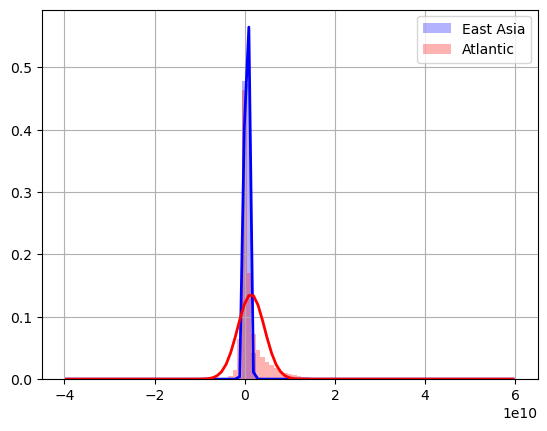

In [236]:
#plt.hist(field_stats1, alpha=0.3, density=True, bins=50, label='East Asia')
#plt.hist(field_stats2, alpha=0.3, density=True, bins=50, label='Atlantic')

field1 = np.array(eddy_local_50_ndjf_moist)[:, 220:240].flatten()
field2 = np.array(eddy_local_50_ndjf_moist)[:, 640:660].flatten()

plot_bins = np.linspace(-4e10, 6e10, 100)

era_fncts.plot_hist_and_gauss(plt, field1, 'b',
                              which_bins=plot_bins, label='East Asia')

era_fncts.plot_hist_and_gauss(plt, field2, 'r',
                              which_bins=plot_bins, label='Atlantic')

plt.legend(loc=0)
plt.grid()
#plt.savefig('figures/4_12_22_meeting/50n_local_ndjf_aht_hists_east_asia_atlantic')
plt.show()



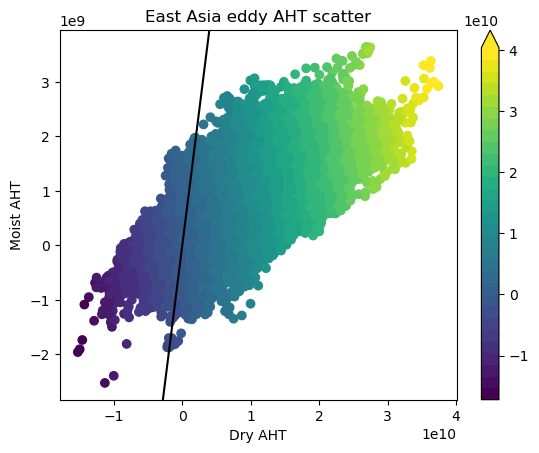

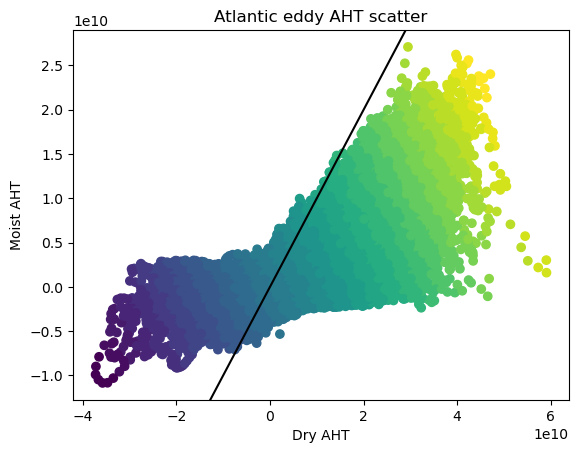

In [244]:
field1 = np.array(eddy_local_50_ndjf)[:, 220:240].flatten()
thresh_95_field1 = np.sort(field1)[int(0.95*len(field1))]

cmap = plt.get_cmap('viridis', 30)
#cmap.set_over('red')

plt.scatter(np.array(eddy_local_50_ndjf_dry)[:, 220:240].flatten(),
            np.array(eddy_local_50_ndjf_moist)[:, 220:240].flatten(),
            c=np.array(eddy_local_50_ndjf)[:, 220:240].flatten(), cmap=cmap)#, vmin=-2e10, vmax=thresh_95_field1)

plt.axline((0,0), slope=1, color='k')
#c=y, cmap=cmap, vmin=-1, vmax=1.5)
plt.colorbar(extend='max')

plt.ylabel('Moist AHT')
plt.xlabel('Dry AHT')
plt.title('East Asia eddy AHT scatter')

#plt.savefig('figures/4_12_22_meeting/east_asia_dry_moist_ndjf_eddy_scatter')
plt.show()

plt.scatter(np.array(eddy_local_50_ndjf_dry)[:, 640:660].flatten(),
            np.array(eddy_local_50_ndjf_moist)[:, 640:660].flatten(),
            c=np.array(eddy_local_50_ndjf)[:, 640:660].flatten(), cmap=cmap)

plt.axline((0,0), slope=1, color='k')
plt.ylabel('Moist AHT')
plt.xlabel('Dry AHT')
plt.title('Atlantic eddy AHT scatter')

#plt.savefig('figures/4_12_22_meeting/atlantic_dry_moist_ndjf_eddy_scatter')
plt.show()

In [142]:
f_x_all = np.zeros((129, len(lons)))
Px_all = np.zeros((129, len(lons)))

for idx,lon in enumerate(lons):
    
    
    [f_x, Px, rspec, end_ratio, F_crit] = era_fncts.time_spectra(eddy_local_50[:,idx])
    
    f_x_all[:,idx] = f_x
    Px_all[:,idx] = Px

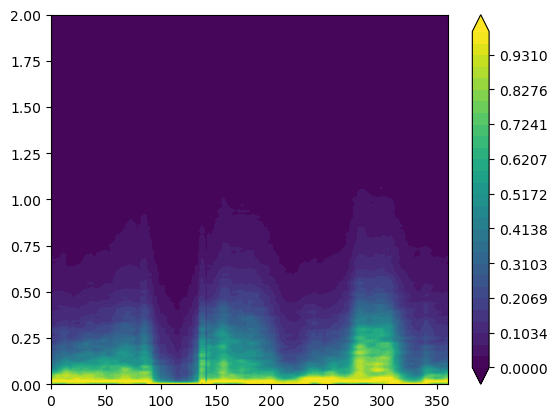

In [154]:
plt.contourf(lons, f_x, Px_all / np.amax(Px_all, axis=0), levels=np.linspace(0, 1, 30), extend='both')

plt.colorbar()

plt.show()

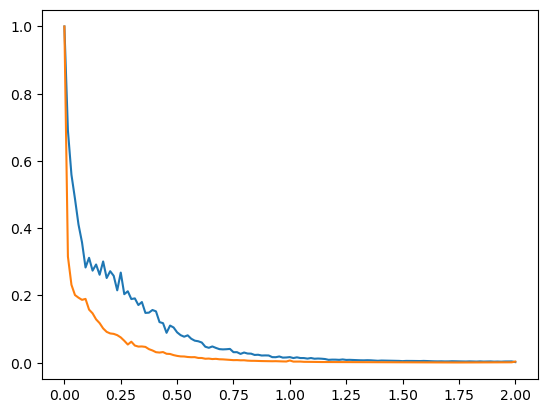

In [157]:
plt.plot(f_x, Px_all[:, 650] / np.amax(Px_all[:,650]))
plt.plot(f_x, Px_all[:, 230] / np.amax(Px_all[:,230]))
plt.show()

In [213]:
hist_values = pd.Series(np.random.normal(1, 2, 5000))

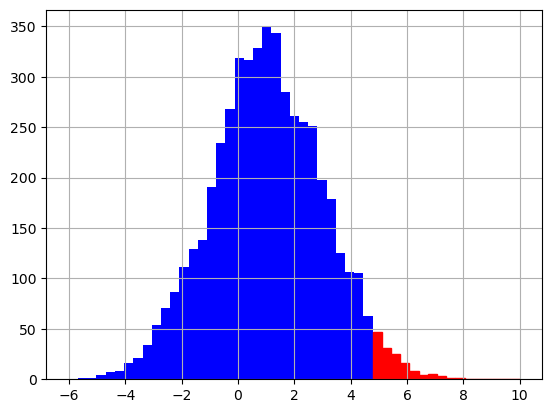

In [217]:
which_bins = np.linspace(-6, 10, 50)



hist_95 = np.sort(np.array(hist_values))[int(0.95 * len(hist_values))]

bars_above_95 = which_bins[which_bins>hist_95]


N, bins, patches = plt.hist(hist_values, bins=which_bins, color='b') #hist_values.plot(kind='hist', bins=which_bins, color='blue')

# Get the indices of the histogram bar that contains those values.
patch_indices = np.digitize([bars_above_95], which_bins)[0]

#print(patch_indices)

for patch_index in patch_indices[:-2]:
    # That's it!
    patches[patch_index].set_color('r')
    
    
plt.grid()

plt.show()

In [220]:
hist_above_95 = np.sort(np.array(hist_values))[int(0.95 * len(hist_values)):]

hist_values_new = hist_values

hist_values_new[hist_values_new<0] = 0

print(np.sum(hist_above_95) / np.sum(np.array(hist_values_new)))

0.18141052950472508


In [274]:
top_5_percs = np.zeros(len(lons))

for idx, lon in enumerate(lons):
    top_5_percs[idx] = get_top_5_gaus(np.array(eddy_local_50_ndjf_moist)[:,idx])


In [275]:
top_5_percs_all = get_top_5_gaus(np.array(eddy_local_50_ndjf_moist)[:,:])

In [276]:
ave_aht = np.mean(eddy_local_50_ndjf_moist, axis=0)

ave_aht_sorted = np.sort(ave_aht)

threhold_value = ave_aht_sorted[int(0.75 * len(ave_aht_sorted))]

indices = np.where(ave_aht > threhold_value)

top_5_on_indices = top_5_percs[indices]
print(len(indices[0]))
#print(np.sum(ave_aht_sorted[int(0.75 * len(ave_aht_sorted)):]) / np.sum(ave_aht_sorted))

179


0.20583024124912044
0.18985707355892117


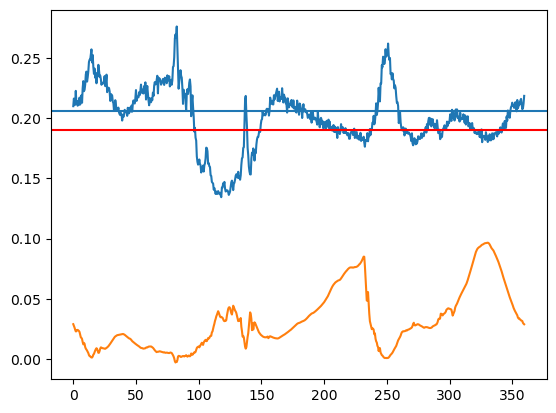

In [277]:
plt.plot(lons, top_5_percs)
plt.plot(lons, np.mean(eddy_local_50_ndjf_moist, axis=0) / 15e9)

plt.axhline(top_5_percs_all)

plt.axhline(np.mean(top_5_on_indices), color='r')

print(top_5_percs_all)
print(np.mean(top_5_on_indices))
plt.show()
